In [6]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression

In [9]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=d53a00d972bd61007415e4a25bad155d10bb3790c5306a19363804b1a0feebbf
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


# **Data Aquisition**

In [10]:
import numpy as np
import pandas as pd

In [11]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project AI/Detection_Real_4k_.csv")

In [12]:
df.sample(3)

,ID,News_Title,News_Text,Published_ Date,Source,Source_URL,Author,Country,Language,Other_Source,Other_Source_URL,News_Type,Party_Affiliation,Location,Region,Subject,Header_Image_URL,Label
2499,2499,Wealth creation to end economic woes,Prime Minister Imran Khan said on Monday that ...,3/8/2021,The Express Tribune,https://tribune.com.pk/story/2313648/wealth-cr...,The Express Tribune,Pakistan,English,Bol News,https://www.bolnews.com/latest/2021/08/kamyab-...,Website,Others,Islamabad,Federal,Economical Politics,https://i.tribune.com.pk/media/images/2201822-...,Real
2879,2879,Punjab moves against LHC order for Rizvi?s rel...,The Punjab government approached the Supreme C...,10/11/2021,The Express Tribune,https://tribune.com.pk/story/2324255/punjab-mo...,Rana Yasif,Pakistan,English,The News,https://www.thenews.com.pk/print/899716-punjab...,Website,Others,Lahore,Punjab,Democratic politics,https://i.tribune.com.pk/media/images/Saad-Riz...,Real
842,842,MODI GOVERNMENT BANS TELECAST OF PSL MATCHES I...,The Bharatiya Janata Party (BJP)-led Indian g...,17/02/2019,Ary News,https://arynews.tv/modi-govt-bans-psl-india/,Ary News,Pakistan and india,English,Times of Islamabad,https://timesofislamabad.com/17-Feb-2019/bjp-g...,Website,Others,Mumbai,India,International Politics,https://arynews.tv/wp-content/uploads/2019/02/...,Real


# **Exploratory data Analysis**

In [13]:
df.shape

(5161, 18)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5161 entries, 0 to 5160
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 5161 non-null   int64 
 1   News_Title         5161 non-null   object
 2   News_Text          5153 non-null   object
 3   Published_ Date    5160 non-null   object
 4   Source             5161 non-null   object
 5   Source_URL         5160 non-null   object
 6   Author             5161 non-null   object
 7   Country            5161 non-null   object
 8   Language           5161 non-null   object
 9   Other_Source       5161 non-null   object
 10  Other_Source_URL   5160 non-null   object
 11  News_Type          5161 non-null   object
 12  Party_Affiliation  5160 non-null   object
 13  Location           5159 non-null   object
 14  Region             5160 non-null   object
 15  Subject            5161 non-null   object
 16  Header_Image_URL   5158 non-null   object


In [15]:
df.isna().sum()

,0
ID,0
News_Title,0
News_Text,8
Published_ Date,1
Source,0
Source_URL,1
Author,0
Country,0
Language,0
Other_Source,0


In [16]:
df.duplicated().sum()

np.int64(0)

# **Data Visualization**

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

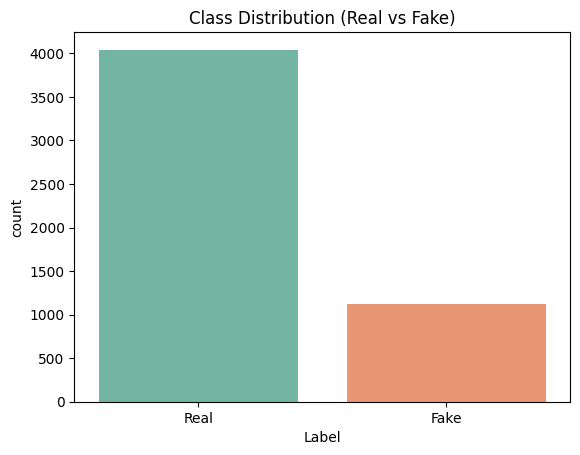

In [18]:
# Class Distribution Bar Plot

sns.countplot(x='Label', data=df, palette='Set2')
plt.title('Class Distribution (Real vs Fake)')
plt.show()

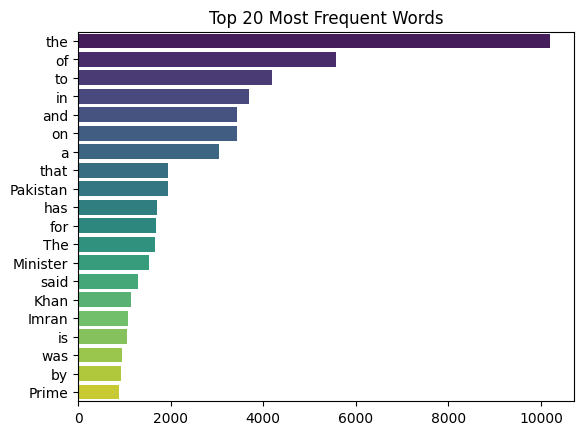

In [19]:
# Word Frequency Bar Plot

from collections import Counter

df['News_Text'] = df['News_Text'].fillna('').astype(str)

all_words = ' '.join(df['News_Text']).split()
word_freq = Counter(all_words).most_common(20)

words, counts = zip(*word_freq)

sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('Top 20 Most Frequent Words')
plt.show()


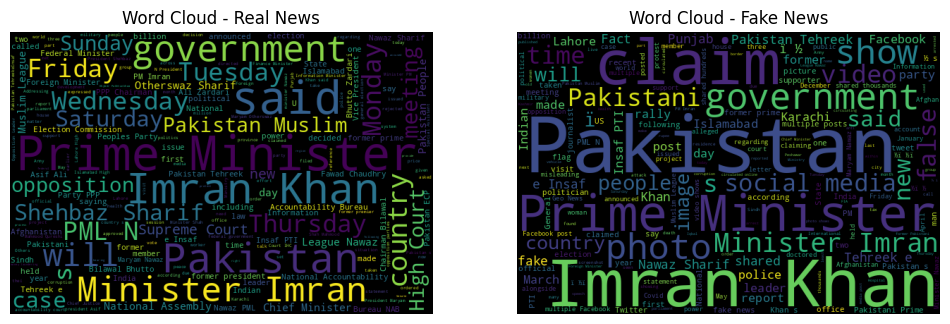

In [20]:
from wordcloud import WordCloud

real_text = ' '.join(df[df['Label']=='Real']['News_Text'].dropna().astype(str))
fake_text = ' '.join(df[df['Label']=='Fake']['News_Text'].dropna().astype(str))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=600, height=400).generate(real_text))
plt.title('Word Cloud - Real News')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400).generate(fake_text))
plt.title('Word Cloud - Fake News')
plt.axis('off')

plt.show()

# **Data Cleaning and Preprocessing**

In [21]:
import re
from bs4 import BeautifulSoup
from langdetect import detect, DetectorFactory, LangDetectException
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [22]:
import nltk

resources = [
    'punkt',
    'punkt_tab',
    'stopwords',
    'wordnet',
    'omw-1.4'
]

for r in resources:
    nltk.download(r)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [23]:
# Drop rows with missing data
df = df.dropna(subset=['News_Text', 'Label']).copy()

In [24]:
# Labeling 0 to real and fake to 1
label_map = {'Real': 0, 'Fake': 1, 0: 0, 1: 1}
df['Label'] = df['Label'].map(label_map)

In [25]:
# Set fixed seed to ensure reproducible language detection results
DetectorFactory.seed = 0

sample = df['News_Text'].dropna().sample(min(300, len(df)), random_state=42).astype(str).tolist()

langs = []
for x in sample:
    text = x.strip()[:500]
    try:
        if len(text) > 20:
            langs.append(detect(text))
        else:
            langs.append("unknown")
    except LangDetectException:
        langs.append("unknown")

pd.Series(langs).value_counts()

,count
en,298
unknown,1
id,1


In [26]:
lemmatizer = WordNetLemmatizer()

url_pattern = re.compile(r'https?://\S+|www\.\S+')

boilerplate_patterns = [ re.compile(r'subscribe|follow us|read more|advertisement|click here', re.I), ]

punct_table = str.maketrans('', '', r'!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~')

In [27]:
def clean_text_basic(text: str) -> str:
    if not isinstance(text, str):
        return ""

    # Remove html
    text = BeautifulSoup(text, "html.parser").get_text(separator=" ")

    # Remove url
    text = url_pattern.sub(' ', text)

    # Normalize whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [28]:
def normalize_english(text: str) -> str:
    text = text.lower()
    for pat in boilerplate_patterns:
        text = pat.sub(' ', text)

    text = text.translate(punct_table)
    text = re.sub(r'\d+', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalpha() and t not in ENGLISH_STOP_WORDS and len(t) > 2]
    return ' '.join(tokens)

In [29]:
def preprocess_text(text: str) -> str:
    base = clean_text_basic(text)
    if not base:
        return ""

    try:
        lang = detect(base[:500])
    except LangDetectException:
        lang = 'en'

    if lang == 'en':
        return normalize_english(base)
    elif lang in ('ur', 'fa', 'ar'):
        return normalize_urdu(base)
    else:
        return normalize_english(base)

In [30]:
# Apply preprocessing
df['content_clean'] = df['News_Text'].astype(str).apply(preprocess_text)
df['len_clean'] = df['content_clean'].str.split().apply(len)
df = df[df['len_clean'] >= 5].copy()

In [31]:
# Drop duplicates
df = df.drop_duplicates(subset=['News_Title', 'content_clean']).copy()

In [32]:
print("Rows after cleaning:", len(df))
print("\nClass balance after cleaning: \n", df['Label'].value_counts(normalize=True))

Rows after cleaning: 5095

Class balance after cleaning: 
 Label
0    0.783513
1    0.216487
Name: proportion, dtype: float64


In [33]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 93.1 MB/s eta 0:00:00


In [34]:
import gensim
from gensim.models import Word2Vec

In [36]:
# Tokenization
tokenized_corpus = [text.split() for text in df['content_clean']]

In [37]:
# Set random seed for reproducibility
SEED = 42

w2v_model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=100,
    window=5,
    min_count=3,
    workers=4,
    sg=1,              # skip-gram for semantic meaning
    seed=SEED
)

In [38]:
# Save model
w2v_model.save("word2vec_fake_news.model")

In [39]:
# Custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

class Word2VecEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, model=w2v_model):
        self.model = model
        self.vector_size = model.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        embeddings = []
        for doc in X.astype(str):
            tokens = doc.split()
            valid_tokens = [t for t in tokens if t in self.model.wv]
            if not valid_tokens:
                embeddings.append(np.zeros(self.vector_size))
            else:
                embeddings.append(np.mean(self.model.wv[valid_tokens], axis=0))
        return np.array(embeddings)

In [40]:
# Word2Vec branch

from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

w2v_branch = Pipeline(steps=[
    ('w2v', Word2VecEmbedder()),
    ('svd', TruncatedSVD(n_components=50, random_state=SEED))
])

In [41]:
# TF-IDF features
text_features = TfidfVectorizer(
    sublinear_tf=True,
    min_df=3,
    max_df=0.9,
    ngram_range=(1,2),
    analyzer='word'
)

char_features = TfidfVectorizer(
    sublinear_tf=True,
    min_df=3,
    max_df=0.95,
    ngram_range=(3,5),
    analyzer='char'
)

In [42]:
# ColumnTransformer
preprocessor_w2v = ColumnTransformer(
    transformers=[
        ('word_tfidf', text_features, 'content_clean'),
        ('char_tfidf', char_features, 'content_clean'),
        ('stylo', StandardScaler(with_mean=False), ['avg_word_len','punct_ratio','upper_ratio','digit_ratio','num_tokens']),
        ('word2vec', w2v_branch, 'content_clean')
    ],
    remainder='drop'
)

In [43]:
# Pipeline
model_w2v = Pipeline(steps=[
    ('prep', preprocessor_w2v),
    ('clf', LogisticRegression(
        solver='liblinear',
        C=1.0,
        class_weight='balanced',
        max_iter=400
    ))
])

In [45]:
# Stylometric feature
def stylometry_features(text: str) -> dict:
    tokens = text.split()
    if not tokens:
        return {
            'avg_word_len': 0, 'punct_ratio': 0, 'upper_ratio': 0,
            'digit_ratio': 0, 'num_tokens': 0
        }
    avg_word_len = np.mean([len(t) for t in tokens])
    puncts = re.findall(r'[^\w\s]', text)
    punct_ratio = len(puncts) / max(1, len(text))
    upper_ratio = sum(1 for c in text if c.isupper()) / max(1, len(text))
    digit_ratio = sum(1 for c in text if c.isdigit()) / max(1, len(text))
    return {
        'avg_word_len': avg_word_len,
        'punct_ratio': punct_ratio,
        'upper_ratio': upper_ratio,
        'digit_ratio': digit_ratio,
        'num_tokens': len(tokens)
    }

stylo = df['content_clean'].apply(stylometry_features).apply(pd.Series)
df_feat = pd.concat([df[['content_clean', 'Label']], stylo], axis=1)

In [46]:
# Train/test split
X = df_feat.drop(columns=['Label'])
y = df_feat['Label'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

In [47]:
# Fit model
model_w2v.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('word_tfidf',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  min_df=3,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  sublinear_tf=True),
                                                  'content_clean'),
                                                 ('char_tfidf',
                                                  TfidfVectorizer(analyzer='char',
                                                                  max_df=0.95,
                                                                  min_df=3,
                                                                  ngram_range=(3,
                                                                               5),
                                                                  sublinear_tf=True),
                                                  'content_clean'),
                                                 ('stylo',
                                                  StandardScaler(with_mean=False),
                                                  ['avg_word_len',
                                                   'punct_ratio', 'upper_ratio',
                                                   'digit_ratio',
                                                   'num_tokens']),
                                                 ('word2vec',
                                                  Pipeline(steps=[('w2v',
                                                                   Word2VecEmbedder()),
                                                                  ('svd',
                                                                   TruncatedSVD(n_components=50,
                                                                                random_state=42))]),
                                                  'content_clean')])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=400,
                                    solver='liblinear'))])

In [51]:
# Evaluate
y_pred = model_w2v.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8792934249263984


In [49]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9256    0.9198    0.9227       798
           1     0.7168    0.7330    0.7248       221

    accuracy                         0.8793      1019
   macro avg     0.8212    0.8264    0.8238      1019
weighted avg     0.8803    0.8793    0.8798      1019



In [50]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[734  64]
 [ 59 162]]


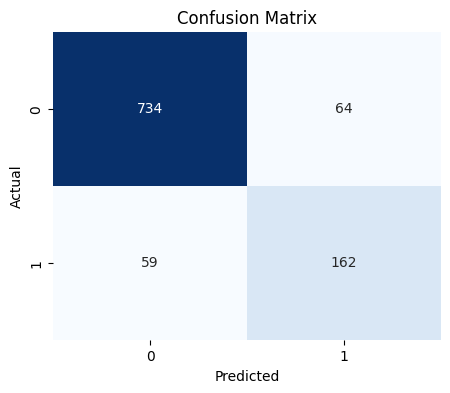

In [52]:
# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

In [53]:
import joblib
joblib.dump(model_w2v , "fake_news_model_lr.joblib")

['fake_news_model_lr.joblib']

In [54]:
from google.colab import files
files.download("fake_news_model_lr.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
testing = joblib.load("fake_news_model_lr.joblib")

In [56]:
def build_features(text: str) -> pd.DataFrame:
    cleaned = preprocess_text(text)  # your preprocessing function

    row = {
        'content_clean': cleaned,
        'avg_word_len': np.mean([len(t) for t in cleaned.split()]) if cleaned else 0,
        'punct_ratio': len(re.findall(r'[^\w\s]', cleaned)) / max(1, len(cleaned)),
        'upper_ratio': sum(1 for c in cleaned if c.isupper()) / max(1, len(cleaned)),
        'digit_ratio': sum(1 for c in cleaned if c.isdigit()) / max(1, len(cleaned)),
        'num_tokens': len(cleaned.split()) if cleaned else 0
    }
    return pd.DataFrame([row])

In [57]:

def predict_article(text: str) -> dict:
    X_row = build_features(text)
    prob = testing.predict_proba(X_row)[0, 1]
    pred = int(prob >= 0.5)
    return {
        'prediction': 'Fake' if pred == 1 else 'Real',
        'prob_fake': float(prob)
    }

In [62]:
sample_text = "Is imran khan alive"
print(predict_article(sample_text))

{'prediction': 'Fake', 'prob_fake': 0.9801426485587842}
